# Medicine Box detection algorithm 

In [1]:
import tensorflow as tf 
import tensorflow.keras.layers as layers 
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optim
from tensorflow.keras.regularizers import l2, l1

import os 
import cv2
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.sparse import csr_matrix
import traceback

## Control values 

In [2]:
PATH = r"MedicineBoxes"
IMG  = (512, 512, 3)
GRID = (8, 8)
FAC = IMG[0] / GRID[0]

DEF_NUM = 4
DEF_KER = 3
DEF_STR = 1
MOMENT = 0.9
KREG = 1e-4
BREG = 1e-6
ACTF = "silu"
VRED = 0.7
XFAC = 1.5

In [3]:
A2V = lambda x: x.reshape(-1, 1)
_2L = lambda x: [int(x)] if type(x) == type(int()) else [int(c) for c in x]

In [4]:


def find_class_indexes(classes):
    class_list = list(set(classes))
    datapoint_index = A2V(np.array([class_list.index(data) for data in classes]))
    return class_list, datapoint_index

def make_grid(xmin, ymin, xmax, ymax, image_indexes, imgset, class_indexes, factor=FAC):
    base_shape = np.zeros(((len(imgset), ) +  GRID + (6,)))
    centerx = (xmax + xmin) / 2.0
    centery = (ymax + ymin) / 2.0
    width = A2V((xmax - xmin) / 2.0)
    height = A2V((ymax - ymin) / 2.0)
    boxx = np.array(centerx / factor, dtype="uint8") 
    boxy = np.array(centery / factor, dtype="uint8") 
    
    centerx = A2V((centerx % factor) / factor) 
    centery = A2V((centery % factor) / factor)
    width = width / factor 
    height = height / factor 
    print(image_indexes.shape, boxx.shape, boxy.shape)

    base_shape[image_indexes, boxx, boxy, :] = np.concatenate([class_indexes, np.ones((class_indexes.shape)), centerx, centery, width, height], axis=1)
    return base_shape
    

def read_folder(PATH, annotation = "_annotations.csv"):
    base_path = os.getcwd()
    try:
        os.chdir(PATH)
        dataset = pd.read_csv(annotation).values
        image_set = list(set(dataset[:, 0]))
        image_indexes = np.array([image_set.index(data) for data in  dataset[:, 0]])
        x_train = np.array([cv2.resize(cv2.imread(datapoint), IMG[:2], cv2.INTER_CUBIC) for datapoint in image_set])
        print(type(image_indexes[0]))

        W, H = dataset[:, 1:3].T
        xmin, ymin, xmax, ymax = dataset[:, -4:].T
        xmin = xmin * (IMG[0] / W )
        xmax = xmax * (IMG[0] / W )
        ymin = ymin * (IMG[1] / H )
        ymax = ymax * (IMG[1] / H )
        class_list, class_indexes = find_class_indexes(dataset[:, 3])
        y_train = make_grid(xmin, ymin, xmax, ymax, image_indexes, image_set, class_indexes, FAC)
        os.chdir(base_path)
        return x_train, y_train, class_list
         
    except Exception as e:
        os.chdir(base_path)
        error_message = traceback.print_exc()
        print(error_message)

    

In [5]:
folders = os.listdir(PATH)

xtrain, ytrain, classes = read_folder(PATH + "/" + folders[2] )

<class 'numpy.int64'>
(4248,) (4248,) (4248,)


In [6]:
ytrain.shape

(2661, 8, 8, 6)

In [7]:
def point_reader(ytr, factor = FAC):
    sparse_matrix_list = [csr_matrix(ytr[:, :, c]).tocoo() for c in range(ytr.shape[-1])]

    centerx = sparse_matrix_list[2].row * factor + sparse_matrix_list[2].data * factor
    centery = sparse_matrix_list[2].col * factor + sparse_matrix_list[3].data * factor

    width_by_2  = sparse_matrix_list[4].data * factor
    height_by_2 = sparse_matrix_list[5].data * factor
    
    xmin_list = _2L(centerx - width_by_2)
    ymin_list = _2L(centery - height_by_2)
    xmax_list = _2L(centerx + width_by_2)
    ymax_list = _2L(centery + height_by_2)
    return xmin_list, ymin_list, xmax_list, ymax_list, list(sparse_matrix_list[0].data)


def plot_box(image, ytr, factor = FAC):
    xmin_list, ymin_list, xmax_list, ymax_list, _ = point_reader(ytr, factor)
    for xmin, ymin, xmax, ymax in zip(xmin_list, ymin_list, xmax_list, ymax_list):
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 1, 1)
    plt.imshow(image)

def IoU(ypred, ytrue, factor = FAC):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = point_reader(ypred, factor)
    xmin_true, ymin_true, xmax_true, ymax_true = point_reader(ytrue, factor)

    int_x_min = max(xmin_true, xmin_pred)
    int_y_min = max(ymin_pred, ymin_true)
    int_x_max = min(xmax_true, xmax_pred)
    int_y_max = min(ymax_pred, ymax_true)

    int_width  = int_x_max - int_x_min 
    int_height = int_y_max - int_y_min

    int_area = int_width * int_height 

    pred_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_area = (xmax_true - xmax_true) * (ymax_true - ymin_true)

    uno_area = pred_area + true_area - int_area 

    return int_area / uno_area

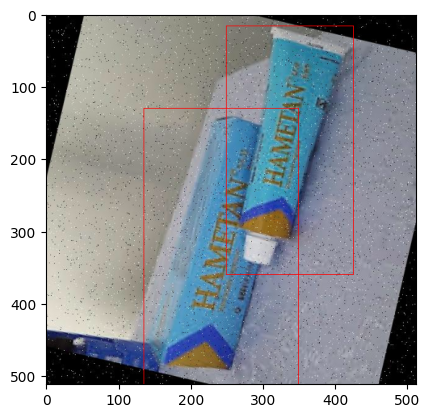

In [8]:
c = random.randint(0, 2000)
plot_box(xtrain[c], ytrain[c])

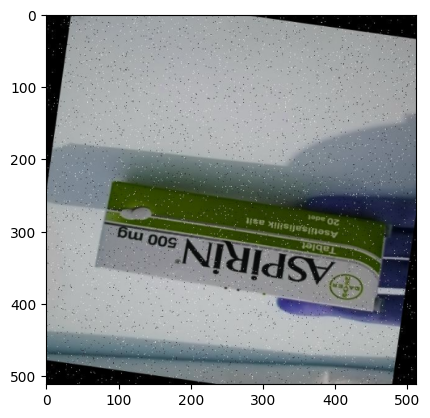

In [9]:
plt.imshow(xtrain[1])

In [10]:
def se_block(input_tensor, reduction_ratio=32, kernel_reg=1e-4, drop_se=0.3):
    channels = input_tensor.shape[-1]
    x = layers.GlobalAveragePooling2D()(input_tensor)
    x = layers.Reshape((1, 1, channels))(x)
    x = layers.Dense(channels // reduction_ratio, activation='relu', use_bias=False, kernel_regularizer=l2(kernel_reg))(x)
    x = layers.Dropout(drop_se)(x)
    x = layers.Dense(channels, activation='sigmoid', use_bias=False, kernel_regularizer=l2(kernel_reg))(x)
    output = layers.Multiply()([input_tensor, x])
    return output

In [11]:
def ConvOp(x, resx, denx:list, filters:int, num:int = DEF_NUM, kernel:int = DEF_KER, 
           stride:int = DEF_STR, moment:float = MOMENT, activation:str=ACTF, 
           kernel_reg:float=KREG, bias_reg:float=BREG, var_red:float=VRED, xp_factor = XFAC):
    factor = 1 / num
    MBilters = int((filters * factor) * xp_factor)
    xlist = denx

    kernels = range(-(kernel // 2), num - kernel // 2) if num > 1 else range(1)

    for c in kernels:
        reduce = abs(c) * var_red if c != 0 else 1
        rilters = int(MBilters / reduce)
        xl = layers.Conv2D(rilters, kernel + 2*c, padding="same", strides= stride,
                           kernel_regularizer=l2(kernel_reg), 
                           bias_regularizer=l1(bias_reg))(x)
        xl = layers.BatchNormalization(momentum=moment)(xl)
        xlist.append(xl)
    xl = layers.MaxPool2D(3, stride, padding="same")(x)
    xl = layers.BatchNormalization(momentum=moment)(xl)

    xlist.append(xl)
    x = layers.Concatenate()(xlist)
    x = layers.Activation(activation)(x)

    x = layers.Conv2D(filters, kernel, padding="same", 
                      kernel_regularizer=l2(kernel_reg), 
                      bias_regularizer=l1(bias_reg))(x)
    x = se_block(x)
    nesx = layers.BatchNormalization(momentum=moment)(x)
    x = layers.Activation(activation)(nesx + resx)

    denx.append(x)
    return x, nesx, denx

In [12]:
def ConvBlock(x, residual_connect, dense_connect, filters, num_delta_x, 
              kernel:int = DEF_KER, moment:float = MOMENT, activation:str=ACTF, 
              kernel_reg:float=KREG, bias_reg:float=BREG, var_red:float=VRED, xp_factor = XFAC):
    
    for c, dense in enumerate(dense_connect):
        dense = layers.Conv2D(filters, 3, padding="same", strides=2,
                         kernel_regularizer = l2(kernel_reg), 
                         bias_regularizer = l1(bias_reg))(dense)
        dense = layers.BatchNormalization(momentum=moment)(dense)
        dense_connect[c] = layers.Activation(activation)(dense)
    
    if dense_connect != []:
        denx = layers.Concatenate()(dense_connect)
        denx = layers.Conv2D(filters, kernel, padding="same",
                            kernel_regularizer = l2(kernel_reg), 
                            bias_regularizer = l1(bias_reg))(denx)
        denx = layers.BatchNormalization(momentum=moment)(denx)
        denx = [denx]
    else:
        denx = []
    

    resx1 = layers.Conv2D(filters, 3, strides=2, padding="same",
                         kernel_regularizer = l2(kernel_reg), 
                         bias_regularizer = l1(bias_reg))(residual_connect)
    
    resx2 = layers.MaxPool2D(2, 2)(residual_connect)
    resx2 = layers.Conv2D(filters, 1,
                         kernel_regularizer = l2(kernel_reg), 
                         bias_regularizer = l1(bias_reg))(resx2)
    
    resx = resx1 + resx2
    
    for c, num in enumerate(num_delta_x):
        stride = 1 if c!=0 else 2
        x, resx, denx = ConvOp(x, resx, denx, filters, num, kernel, stride, moment, 
                               activation, kernel_reg, bias_reg)
    
    denx = layers.Concatenate()(denx)
    denx = layers.Conv2D(filters, kernel, padding="same",
                         kernel_regularizer = l2(kernel_reg), 
                         bias_regularizer = l1(bias_reg))(denx)
    denx = layers.BatchNormalization(momentum=moment)(denx)
    denx = layers.Activation(activation)(denx)

    dense_connect.append(denx)

    return x, resx, dense_connect

In [13]:
def CNN(input_shape = IMG, num_num = [[3]*2, [3]*3, [2]*6, [1]*3], filters=64, classes = 40, 
         kernel:int = DEF_KER, moment:float = MOMENT, activation:str=ACTF, kernel_reg:float=KREG, 
         bias_reg:float=BREG, var_red:float=VRED, xp_factor = XFAC, gf=2):
    inp = layers.Input(input_shape)
    x = layers.Conv2D(filters, 7, padding="same", strides=2, 
                      kernel_regularizer=l2(kernel_reg), 
                      bias_regularizer = l1(bias_reg))(inp) # 256
    x = layers.Activation(activation)(x)
    resx = layers.Conv2D(filters * gf, 7, padding="same", strides=2, 
                      kernel_regularizer=l2(kernel_reg), 
                      bias_regularizer = l1(bias_reg))(x) # 256
    x = layers.Activation(activation)(resx)

    dense_connect = []
    for num in num_num:
        filters = filters * gf
        x, resx, dense_connect = ConvBlock(x, resx, dense_connect, filters, num, kernel, moment, 
                                           activation, kernel_reg, bias_reg, var_red, xp_factor)
        # 64, 32, 16, 8

    x = layers.Conv2D(filters, 1, padding="same", 
                      kernel_regularizer=l2(kernel_reg), 
                      bias_regularizer = l1(bias_reg))(x)
    x = layers.BatchNormalization(momentum = moment)(x)
    x = layers.Activation(activation)(x)
    
    classfication = layers.Conv2D(classes, 1, padding="same", 
                      kernel_regularizer=l2(kernel_reg), 
                      bias_regularizer = l1(bias_reg), activation = "softmax")(x)
    
    confidence = layers.Conv2D(1, 1,  kernel_regularizer=l2(kernel_reg), 
                      bias_regularizer = l1(bias_reg), activation = "sigmoid")(x)
    boxes = layers.Conv2D(4, 1,  kernel_regularizer=l2(kernel_reg), 
                      bias_regularizer = l1(bias_reg), activation = "relu")(x)
    
    out = layers.Concatenate()([confidence, boxes, classfication])
    
    model = models.Model(inputs=inp, outputs=out )
    return model

    


In [14]:
model = CNN()
model.summary()

2024-11-27 13:48:46.919056: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-11-27 13:48:46.919082: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2024-11-27 13:48:46.919085: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
2024-11-27 13:48:46.919112: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-27 13:48:46.919124: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 128)        401536    ['activation[0][0]']          
                                                                                              

In [15]:
def point_reader_tensor(ytr, factor=FAC):
    """
    Reads points and calculates bounding box coordinates for TensorFlow tensors.
    """
    # Extract sparse matrix channels as tensors
    centerx = ytr[..., 2] * factor
    centery = ytr[..., 3] * factor
    width_by_2 = ytr[..., 4] * factor
    height_by_2 = ytr[..., 5] * factor
    
    # Compute bounding box coordinates
    xmin = centerx - width_by_2
    ymin = centery - height_by_2
    xmax = centerx + width_by_2
    ymax = centery + height_by_2

    return xmin, ymin, xmax, ymax


def IoU_tensor(y_pred, y_true, factor=1.0):
    """
    Computes IoU for tensors with 4 bounding box channels.
    """
    # Get bounding box coordinates
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = point_reader_tensor(y_pred, factor)
    xmin_true, ymin_true, xmax_true, ymax_true = point_reader_tensor(y_true, factor)

    # Compute intersection coordinates
    int_xmin = tf.maximum(xmin_pred, xmin_true)
    int_ymin = tf.maximum(ymin_pred, ymin_true)
    int_xmax = tf.minimum(xmax_pred, xmax_true)
    int_ymax = tf.minimum(ymax_pred, ymax_true)

    # Compute intersection area
    int_width = tf.maximum(0.0, int_xmax - int_xmin)
    int_height = tf.maximum(0.0, int_ymax - int_ymin)
    int_area = int_width * int_height

    # Compute areas of predicted and true boxes
    pred_area = tf.maximum(0.0, (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred))
    true_area = tf.maximum(0.0, (xmax_true - xmin_true) * (ymax_true - ymin_true))

    # Compute union area
    union_area = pred_area + true_area - int_area

    # Compute IoU
    iou = tf.where(union_area > 0, int_area / union_area, tf.zeros_like(int_area))
    return iou


In [16]:
def loss_function(y_true, y_pred):
    # Ensure both y_true and y_pred are tensors
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)
    
    # Calculate IoU loss
    iou_loss = 1 - IoU_tensor(y_pred[..., 2:], y_true[..., 2:])  # Assuming IoU is defined using TensorFlow operations
    
    # Calculate regression loss
    regression_loss = tf.keras.losses.mean_absolute_error(y_true[..., 2:], y_pred[..., 2:])
    
    # Calculate binary crossentropy loss
    bce_loss = tf.keras.losses.binary_crossentropy(y_true[..., 1:2], y_pred[..., 1:2])
    
    # Calculate sparse categorical crossentropy loss
    multi_class_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true[..., 0:1], y_pred[..., 0:1])
    
    # Combine all losses
    total_loss = iou_loss + bce_loss + multi_class_loss + regression_loss
    return total_loss


In [17]:
model.compile(optimizer=optim.legacy.Adam(learning_rate=1e-4), loss = loss_function, metrics=[IoU])
model.fit(xtrain, ytrain, epochs=1, verbose=1)

ValueError: in user code:

    File "/Users/suyashsachdeva/Desktop/जालप्रक्रिया/ADD/textreco/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/var/folders/_x/dl3hm0q55ldf2ftjm2g8_3x80000gn/T/ipykernel_11682/2561188851.py", line 7, in loss_function  *
        iou_loss = 1 - IoU_tensor(y_pred[..., 2:], y_true[..., 2:])  # Assuming IoU is defined using TensorFlow operations
    File "/var/folders/_x/dl3hm0q55ldf2ftjm2g8_3x80000gn/T/ipykernel_11682/1354241441.py", line 26, in IoU_tensor  *
        xmin_true, ymin_true, xmax_true, ymax_true = point_reader_tensor(y_true, factor)
    File "/var/folders/_x/dl3hm0q55ldf2ftjm2g8_3x80000gn/T/ipykernel_11682/1354241441.py", line 8, in point_reader_tensor  *
        width_by_2 = ytr[..., 4] * factor

    ValueError: slice index 4 of dimension 3 out of bounds. for '{{node loss_function/strided_slice_8}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=0, ellipsis_mask=1, end_mask=0, new_axis_mask=0, shrink_axis_mask=2](loss_function/strided_slice_1, loss_function/strided_slice_8/stack, loss_function/strided_slice_8/stack_1, loss_function/strided_slice_8/stack_2)' with input shapes: [?,8,8,4], [2], [2], [2] and with computed input tensors: input[1] = <0 4>, input[2] = <0 5>, input[3] = <1 1>.
